In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models,layers
from imgaug import augmenters as iaa
import imgaug as ia
from sklearn.metrics import classification_report
import itertools

In [2]:
!pip install tensorflow

  Preparing metadata (setup.py) ... - done
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77055 sha256=31c9efb2c98a4e816e907648bade736c76a13256faa39226e1980ab39abed1cc
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Successfully uninstalled wrapt-1.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

In [3]:
df = pd.read_csv('../input/isic-2019-challenge/ISIC_2019_Training_GroundTruth.csv')
df_train = pd.read_csv('../input/pastas-de-dados/df_train.csv')
df_val = pd.read_csv('../input/pastas-de-dados/df_val.csv')
df_test = pd.read_csv('../input/pastas-de-dados/df_test.csv')

base_dir = '../input/isic-2019-challenge/ISIC_2019_Training_Input/ISIC_2019_Training_Input'

In [4]:
df_train = df_train.assign(label=0)
df_train.loc[df_train['MEL']==1.0, 'label'] = 1
df_train.loc[df_train['BCC']==1.0, 'label'] = 1
df_train.loc[df_train['VASC']==1.0, 'label'] = 1
df_train.loc[df_train['SCC']==1.0, 'label'] = 1

In [5]:
df_val = df_val.assign(label=0)
df_val.loc[df_val['MEL']==1.0, 'label'] = 1
df_val.loc[df_val['BCC']==1.0, 'label'] = 1
df_val.loc[df_val['VASC']==1.0, 'label'] = 1
df_val.loc[df_val['SCC']==1.0, 'label'] = 1

In [6]:
df_test = df_test.assign(label=0)
df_test.loc[df_test['MEL']==1.0, 'label'] = 1
df_test.loc[df_test['BCC']==1.0, 'label'] = 1
df_test.loc[df_test['VASC']==1.0, 'label'] = 1
df_test.loc[df_test['SCC']==1.0, 'label'] = 1

In [7]:
tf.random.set_seed(42)
ia.seed(42)

rand_aug = iaa.RandAugment(n=1, m=2)

def augment(image):
    image = tf.cast(image, tf.uint8)
    return rand_aug(image=image.numpy())

def random_crop(image,aspect_ratio_range=[0.75, 1.33],area_range=[0.08, 1],min_object_covered=0.5,max_attempts=100,seed=0):
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
    tf.shape(image),
    bounding_boxes=bbox,
    min_object_covered=min_object_covered,
    area_range=area_range,
    aspect_ratio_range=aspect_ratio_range,
    use_image_if_no_bounding_boxes=True,
    max_attempts=max_attempts,
    seed=seed)
    offset_height, offset_width, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)

    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.crop_to_bounding_box(image,offset_height,offset_width,target_height,target_width)

    return image

In [8]:
def loadImage(image,label):
 image = tf.io.read_file(base_dir + '/' + image + '.jpg')
 image = tf.io.decode_jpeg(image,channels=3)
 

 return image,label


def dataAument(image,label):
 image = random_crop(image)
 image = tf.image.convert_image_dtype(image, dtype=tf.float32)
 image = tf.image.resize(image,size = (224,224)) #EfficientNetB2
 image = tf.image.random_flip_left_right(image)
 image = tf.image.random_flip_up_down(image)
 image_shape = tf.shape(image)
 image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
 image2 = tf.py_function(augment,[image],[tf.float32])[0]
 image = tf.ensure_shape(image2,shape=image.get_shape())

 return image,label
 
def resize(image,label):
    image = tf.image.resize(image,size = (224,224)) #EfficientNetB0

    return image,label

In [9]:
dataSet_train = tf.data.Dataset.from_tensor_slices((df_train['image'],df_train['label']))

dataSet_train = dataSet_train.shuffle(len(df_train))
dataSet_train = dataSet_train.map(loadImage)
dataSet_train = dataSet_train.map(dataAument)

dataSet_train = dataSet_train.batch(64)

2021-12-09 05:06:30.917743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 05:06:31.009610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 05:06:31.010351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 05:06:31.014536: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
dataSet_val = tf.data.Dataset.from_tensor_slices((df_val['image'],df_val['label']))

dataSet_val = dataSet_val.map(loadImage)
dataSet_val = dataSet_val.map(resize)
dataSet_val = dataSet_val.batch(64)

In [11]:
dataSet_test = tf.data.Dataset.from_tensor_slices((df_val['image'],df_val['label']))

dataSet_test = dataSet_test.map(loadImage)
dataSet_test = dataSet_test.map(resize)
dataSet_test = dataSet_test.batch(64)

2021-12-09 05:06:33.815463: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(64, 224, 224, 3)


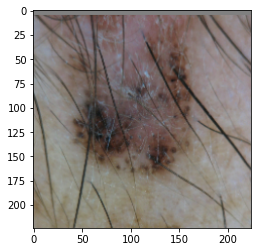

In [12]:
for sample in dataSet_train.take(1):
  print(sample[0].shape)
  plt.imshow(sample[0][0]/255)
  plt.show()

In [13]:
conv_base = EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3))

conv_base.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________

In [14]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [15]:
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=["acc"])

H = model.fit(dataSet_train,epochs=40,validation_data = dataSet_val)

Epoch 1/40


2021-12-09 05:06:49.794756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


317/317 [==============================] - 688s 2s/step - loss: 0.4763 - acc: 0.7673 - val_loss: 0.4592 - val_acc: 0.7936
Epoch 2/40
317/317 [==============================] - 649s 2s/step - loss: 0.4192 - acc: 0.8047 - val_loss: 0.4545 - val_acc: 0.7991
Epoch 3/40
317/317 [==============================] - 619s 2s/step - loss: 0.3954 - acc: 0.8166 - val_loss: 0.4035 - val_acc: 0.8165
Epoch 4/40
317/317 [==============================] - 588s 2s/step - loss: 0.3735 - acc: 0.8329 - val_loss: 0.4214 - val_acc: 0.8122
Epoch 5/40
317/317 [==============================] - 588s 2s/step - loss: 0.3640 - acc: 0.8351 - val_loss: 0.4103 - val_acc: 0.8208
Epoch 6/40
317/317 [==============================] - 613s 2s/step - loss: 0.3536 - acc: 0.8408 - val_loss: 0.3664 - val_acc: 0.8350
Epoch 7/40
317/317 [==============================] - 601s 2s/step - loss: 0.3371 - acc: 0.8498 - val_loss: 0.3908 - val_acc: 0.8343
Epoch 8/40
317/317 [==============================] - 592s 2s/step - loss: 0.324

In [16]:
results = model.evaluate(dataSet_test)
print("test loss, test acc:", results)

40/40 [==============================] - 16s 389ms/step - loss: 0.3787 - acc: 0.8773
test loss, test acc: [0.378675639629364, 0.8772691488265991]


In [17]:
def print_curva(H):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,2)
    plt.plot(H.history['loss'], label='Perda')
    plt.plot(H.history['val_loss'], label='Val_Perda')
    plt.legend()
    plt.title('Perda')
    plt.show()


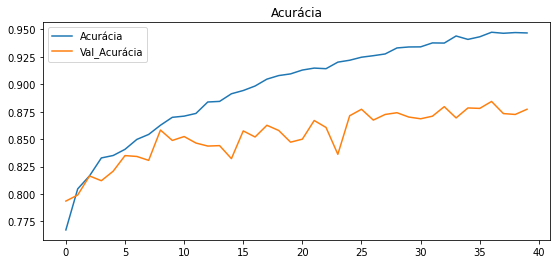

In [18]:
def print_curva2(H):
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,2)
    plt.plot(H.history['acc'], label='Acurácia')
    plt.plot(H.history['val_acc'], label='Val_Acurácia')
    plt.legend()
    plt.title('Acurácia')
    plt.show()


print_curva2(H)